# Dependencies


In [1]:
!pip install --no-deps '../input/timm-package/timm-0.1.26-py3-none-any.whl' > /dev/null
!pip install --no-deps '../input/pycocotools/pycocotools-2.0-cp37-cp37m-linux_x86_64.whl' > /dev/null

In [2]:
import sys

# 라이브러리 path 추가
sys.path.insert(0, "../input/timm-efficientdet-pytorch")
sys.path.insert(0, "../input/omegaconf")
sys.path.insert(0, "../input/weightedboxesfusion")

import ensemble_boxes
import torch
import numpy as np
import pandas as pd
from glob import glob
from torch.utils.data import Dataset,DataLoader
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
import cv2
import gc
from matplotlib import pyplot as plt


# from effdet.config import get_efficientdet_config
# from effdet.efficientdet import EfficientDet
# from effdet.bench import DetBenchEval
from effdet import get_efficientdet_config, EfficientDet, DetBenchEval
from effdet.efficientdet import HeadNet

# Data Loader

In [3]:
DATA_ROOT_PATH = '../input/global-wheat-detection/test'

In [4]:
# Data Loader

class DatasetRetriever(Dataset):
    
    def __init__(self, image_ids, transforms=None):
        super().__init__()
        self.image_ids = image_ids
        self.transforms = transforms

    def __getitem__(self, index: int):
        
        # index에 해당하는 이미지를 읽어들인 뒤 전처리
        image_id = self.image_ids[index]
        image = cv2.imread(f'{DATA_ROOT_PATH}/{image_id}.jpg', cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0
        
        # data augmentation 적용
        if self.transforms:
            sample = {'image': image}
            sample = self.transforms(**sample)
            image = sample['image']
        return image, image_id
    
    def __len__(self) -> int:
        return self.image_ids.shape[0]

In [6]:
# validation dataset data augmentation
# 512x512 크기로 resize 후 Tensor 형태로 변환해줌
def get_valid_transforms():
    return A.Compose([
            A.Resize(height=512, width=512, p=1.0),
            ToTensorV2(p=1.0),
        ], p=1.0)

In [7]:
# DATA_ROOT_PATH에 있는 jpg 이미지 파일을 저장 후 augmentation 적용

dataset = DatasetRetriever(
    image_ids=np.array([path.split('/')[-1][:-4] for path in glob(f'{DATA_ROOT_PATH}/*.jpg')]),
    transforms=get_valid_transforms()
)

In [8]:
# 데이터를 batch 단위로 받는 형식을 지정함

def collate_fn(batch):
    return tuple(zip(*batch))

In [9]:
# data loader

data_loader = DataLoader(
    dataset,
    batch_size=4,
    shuffle=False,
    num_workers=2,
    drop_last=False,
    collate_fn=collate_fn
)

# Load Model

In [10]:
# # 설정파일 유틸리티 라이브러리 Omegaconf를 통해 config 설정을 받아들이는 함수
# def get_efficientdet_config(model_name='tf_efficientdet_d1'):
#     """Get the default config for EfficientDet based on model name."""
#     h = default_detection_model_configs()
#     h.update(efficientdet_model_param_dict[model_name])
#     h.num_levels = h.max_level - h.min_level + 1
#     return h


# # efficientdet_model_param_dict = 모델별 각종 설정을 포함하고 있는 변수
# # 아래는 'tf_efficientdet_d5'
# # 이름, backbone 모델명, 입력 이미지 크기, feature pyramid channel, feature pyramid cell repeats, box classes, backbone argument, model weight download url
# tf_efficientdet_d5=dict(
#         name='tf_efficientdet_d5',
#         backbone_name='tf_efficientnet_b5',
#         image_size=1280,
#         fpn_channels=288,
#         fpn_cell_repeats=7,
#         box_class_repeats=4,
#         backbone_args=dict(drop_path_rate=0.2),
#         url='https://github.com/rwightman/efficientdet-pytorch/releases/download/v0.1/tf_efficientdet_d5-ef44aea8.pth',
#     ),

In [11]:
# # EfficientDet

# class EfficientDet(nn.Module):

#     def __init__(self, config, norm_kwargs=None, pretrained_backbone=True, alternate_init=False):
#         super(EfficientDet, self).__init__()
#         norm_kwargs = norm_kwargs or dict(eps=.001, momentum=.01)
#         self.backbone = create_model(
#             config.backbone_name, features_only=True, out_indices=(2, 3, 4),
#             pretrained=pretrained_backbone, **config.backbone_args)
#         feature_info = get_feature_info(self.backbone)

#         act_layer = get_act_layer(config.act_type)
#         self.fpn = BiFpn(config, feature_info, norm_kwargs=norm_kwargs, act_layer=act_layer)
#         self.class_net = HeadNet(config, num_outputs=config.num_classes, norm_kwargs=norm_kwargs, act_layer=act_layer)
#         self.box_net = HeadNet(config, num_outputs=4, norm_kwargs=norm_kwargs, act_layer=act_layer)

#         for n, m in self.named_modules():
#             if 'backbone' not in n:
#                 if alternate_init:
#                     _init_weight_alt(m, n)
#                 else:
#                     _init_weight(m, n)

#     def forward(self, x):
#         x = self.backbone(x)
#         x = self.fpn(x)
#         x_class = self.class_net(x)
#         x_box = self.box_net(x)
#         return x_class, x_box

In [12]:
# # HeadNet

# class HeadNet(nn.Module):
#     def __init__(self, config, num_outputs, norm_layer=nn.BatchNorm2d, norm_kwargs=None, act_layer=_ACT_LAYER):
#         super(HeadNet, self).__init__()
#         norm_kwargs = norm_kwargs or {}
#         self.config = config
#         num_anchors = len(config.aspect_ratios) * config.num_scales

#         self.conv_rep = nn.ModuleList()
#         self.bn_rep = nn.ModuleList()
#         conv_kwargs = dict(
#             in_channels=config.fpn_channels, out_channels=config.fpn_channels, kernel_size=3,
#             padding=self.config.pad_type, bias=config.redundant_bias, act_layer=None, norm_layer=None)
#         for i in range(config.box_class_repeats):
#             conv = SeparableConv2d(**conv_kwargs) if config.separable_conv else ConvBnAct2d(**conv_kwargs)
#             self.conv_rep.append(conv)

#             bn_levels = []
#             for _ in range(config.num_levels):
#                 bn_seq = nn.Sequential()
#                 bn_seq.add_module('bn', norm_layer(config.fpn_channels, **norm_kwargs))
#                 bn_levels.append(bn_seq)
#             self.bn_rep.append(nn.ModuleList(bn_levels))

#         self.act = act_layer(inplace=True)

#         predict_kwargs = dict(
#             in_channels=config.fpn_channels, out_channels=num_outputs * num_anchors, kernel_size=3,
#             padding=self.config.pad_type, bias=True, norm_layer=None, act_layer=None)
#         if config.separable_conv:
#             self.predict = SeparableConv2d(**predict_kwargs)
#         else:
#             self.predict = ConvBnAct2d(**predict_kwargs)

#     def forward(self, x):
#         outputs = []
#         for level in range(self.config.num_levels):
#             x_level = x[level]
#             for i in range(self.config.box_class_repeats):
#                 x_level_ident = x_level
#                 x_level = self.conv_rep[i](x_level)
#                 x_level = self.bn_rep[i][level](x_level)
#                 x_level = self.act(x_level)
#                 if i > 0 and self.config.fpn_drop_path_rate:
#                     x_level = drop_path(x_level, self.config.fpn_drop_path_rate, self.training)
#                     x_level += x_level_ident
#             outputs.append(self.predict(x_level))
            
#         return outputs

In [13]:
def load_net(checkpoint_path):
    config = get_efficientdet_config('tf_efficientdet_d5') # tf_efficientdet_d5 설정 저장
    net = EfficientDet(config, pretrained_backbone=False)  # EfficientNet 클래스에 설정 포함

    config.num_classes = 1
    config.image_size=512
    net.class_net = HeadNet(config, num_outputs=config.num_classes, norm_kwargs=dict(eps=.001, momentum=.01))

    checkpoint = torch.load(checkpoint_path)
    net.load_state_dict(checkpoint['model_state_dict'])
    
    # garbage collector
    del checkpoint
    gc.collect()
    
    # evaluation mode
    net = DetBenchEval(net, config)
    net.eval();
    return net.cuda()

net = load_net('../input/wheat-effdet5-fold0-best-checkpoint/fold0-best-all-states.bin')

# Custom TTA API

In [14]:
# TTA 추상 클래스 정의
class BaseWheatTTA:
    """ author: @shonenkov """
    image_size = 512
    
    def augment(self, image):
        raise NotImplementedError
    
    def batch_augment(self, images):
        raise NotImplementedError
    
    def deaugment_boxes(self, boxes):
        raise NotImplementedError
        
        
# 좌우 반전 augmentation
class TTAHorizontalFlip(BaseWheatTTA):
    """ author: @shonenkov """

    def augment(self, image):
        return image.flip(1)
    
    def batch_augment(self, images):
        return images.flip(2)
    
    
    # 이미지 좌우 반전 후 x, y의 좌표를 원래대로 돌려주는 함수
    def deaugment_boxes(self, boxes):
        boxes[:, [1,3]] = self.image_size - boxes[:, [3,1]]
        return boxes

# 상하 반전 augmentation
class TTAVerticalFlip(BaseWheatTTA):
    """ author: @shonenkov """
    
    def augment(self, image):
        return image.flip(2)
    
    def batch_augment(self, images):
        return images.flip(3)
    
    def deaugment_boxes(self, boxes):
        boxes[:, [0,2]] = self.image_size - boxes[:, [2,0]]
        return boxes

# 90도 회전 augmentation
class TTARotate90(BaseWheatTTA):
    """ author: @shonenkov """
    
    def augment(self, image):
        return torch.rot90(image, 1, (1, 2))

    def batch_augment(self, images):
        return torch.rot90(images, 1, (2, 3))
    
    def deaugment_boxes(self, boxes):
        res_boxes = boxes.copy()
        res_boxes[:, [0,2]] = self.image_size - boxes[:, [1,3]]
        res_boxes[:, [1,3]] = boxes[:, [2,0]]
        return res_boxes

# augmentation 조합하여 TTA 진행
# 단일 이미지 혹은 batch에 대하여 augmentation 순차적으로 진행
class TTACompose(BaseWheatTTA):
    """ author: @shonenkov """
    def __init__(self, transforms):
        self.transforms = transforms
        
    def augment(self, image):
        for transform in self.transforms:
            image = transform.augment(image)
        return image
    
    def batch_augment(self, images):
        for transform in self.transforms:
            images = transform.batch_augment(images)
        return images
    
    # bounding box의 x,y 좌표와 높이, 넓이 설정
    def prepare_boxes(self, boxes):
        result_boxes = boxes.copy()
        result_boxes[:,0] = np.min(boxes[:, [0,2]], axis=1)
        result_boxes[:,2] = np.max(boxes[:, [0,2]], axis=1)
        result_boxes[:,1] = np.min(boxes[:, [1,3]], axis=1)
        result_boxes[:,3] = np.max(boxes[:, [1,3]], axis=1)
        return result_boxes
    
    def deaugment_boxes(self, boxes):
        for transform in self.transforms[::-1]:
            boxes = transform.deaugment_boxes(boxes)
        return self.prepare_boxes(boxes)

# Demonstration how it works:

In [15]:
def process_det(index, det, score_threshold=0.25):
    boxes = det[index].detach().cpu().numpy()[:,:4]   # box의 좌표
    scores = det[index].detach().cpu().numpy()[:,4]   # confidence score
    boxes[:, 2] = boxes[:, 2] + boxes[:, 0]           # 우상단 x 좌표
    boxes[:, 3] = boxes[:, 3] + boxes[:, 1]           # 우하단 y 좌표
    boxes = (boxes).clip(min=0, max=511).astype(int)  # 512 크기를 초과하는 경우 clip
    indexes = np.where(scores>score_threshold)        # confidence score가 threshold 이상인 경우에 대한 index 반환
    boxes = boxes[indexes]                            # confidence score가 threshold 이상인 경우의 bounding box
    scores = scores[indexes]                          # confidence score가 threshold 이상인 경의의 confidence score
    return boxes, scores                              # bounding box의 좌표, confidence score 반환

In [16]:
# TTA 

transform = TTACompose([
    TTARotate90(),
    TTAVerticalFlip(),
])


# Visualization

/opt/conda/conda-bld/pytorch_1587428398394/work/aten/src/ATen/native/BinaryOps.cpp:81: UserWarning: Integer division of tensors using div or / is deprecated, and in a future release div will perform true division as in Python 3. Use true_divide or floor_divide (// in Python) instead.


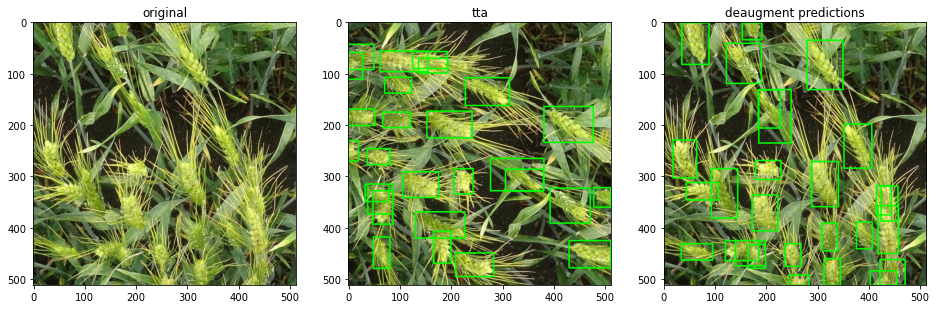

In [17]:
fig, ax = plt.subplots(1, 3, figsize=(16, 6))

image, image_id = dataset[5]

numpy_image = image.permute(1,2,0).cpu().numpy().copy()

ax[0].imshow(numpy_image);
ax[0].set_title('original')

tta_image = transform.augment(image)
tta_image_numpy = tta_image.permute(1,2,0).cpu().numpy().copy()

det = net(tta_image.unsqueeze(0).float().cuda(), torch.tensor([1]).float().cuda())
boxes, scores = process_det(0, det)

for box in boxes:
    cv2.rectangle(tta_image_numpy, (box[0], box[1]), (box[2],  box[3]), (0, 1, 0), 2)

ax[1].imshow(tta_image_numpy);
ax[1].set_title('tta')
    
boxes = transform.deaugment_boxes(boxes)

for box in boxes:
    cv2.rectangle(numpy_image, (box[0], box[1]), (box[2],  box[3]), (0, 1, 0), 2)
    
ax[2].imshow(numpy_image);
ax[2].set_title('deaugment predictions');

# Combinations of TTA

In [18]:
from itertools import product

# 모든 조합의 TTA 실험 가능
# tta_combinations = [(TTAHorizontalFlip, TTAVerticalFlip, TTARotate90), (TTAHorizontalFlip, TTAVerticalFlip, None), ... , (None, None, None)]
# tta_transforms = (None, None, None)인 경우 제외한 모든 조합
tta_transforms = []
for tta_combination in product([TTAHorizontalFlip(), None], 
                               [TTAVerticalFlip(), None],
                               [TTARotate90(), None]):
    tta_transforms.append(TTACompose([tta_transform for tta_transform in tta_combination if tta_transform]))

# WBF over TTA:

In [21]:
def make_tta_predictions(images, score_threshold=0.25):
    with torch.no_grad():
        images = torch.stack(images).float().cuda()
        predictions = []
        for tta_transform in tta_transforms:
            result = []
            
            # TTA한 batch 데이터와 이미지 label을 1로 초기화한 값을 이미지 수만큼
            det = net(tta_transform.batch_augment(images.clone()), torch.tensor([1]*images.shape[0]).float().cuda())

            for i in range(images.shape[0]):
                
                # 예측한 bounding box의 값이 score_threshold 이상일 경우
                boxes = det[i].detach().cpu().numpy()[:,:4]    
                scores = det[i].detach().cpu().numpy()[:,4]
                indexes = np.where(scores > score_threshold)[0]
                boxes = boxes[indexes]
                boxes[:, 2] = boxes[:, 2] + boxes[:, 0]
                boxes[:, 3] = boxes[:, 3] + boxes[:, 1]
                
                # TTA하기 이전 box형태로 되돌려줌
                boxes = tta_transform.deaugment_boxes(boxes.copy())
                
                # box의 좌표와 confidence score 저장
                result.append({
                    'boxes': boxes,
                    'scores': scores[indexes],
                })
                
            # 여러 combination의 TTA 조합 중 하나의 TTA를 실험한 결과의 prediction 저장
            predictions.append(result)
        
    return predictions

In [22]:
# Weighted Box Fusion을 활용하여 최종 box, score, label 반환

def run_wbf(predictions, image_index, image_size=512, iou_thr=0.44, skip_box_thr=0.43, weights=None):
    boxes = [(prediction[image_index]['boxes']/(image_size-1)).tolist() for prediction in predictions]
    scores = [prediction[image_index]['scores'].tolist() for prediction in predictions]
    labels = [np.ones(prediction[image_index]['scores'].shape[0]).astype(int).tolist() for prediction in predictions]
    boxes, scores, labels = ensemble_boxes.ensemble_boxes_wbf.weighted_boxes_fusion(boxes, scores, labels, weights=None, iou_thr=iou_thr, skip_box_thr=skip_box_thr)
    boxes = boxes*(image_size-1)
    return boxes, scores, labels

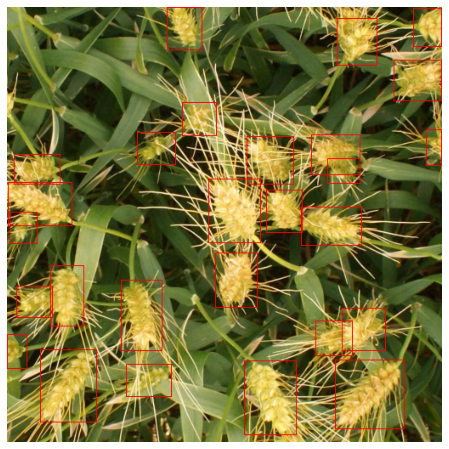

In [23]:
# 예시 시각화

import matplotlib.pyplot as plt

for j, (images, image_ids) in enumerate(data_loader):
    break

predictions = make_tta_predictions(images)

i = 1
sample = images[i].permute(1,2,0).cpu().numpy()

boxes, scores, labels = run_wbf(predictions, image_index=i)
boxes = boxes.round().astype(np.int32).clip(min=0, max=511)

fig, ax = plt.subplots(1, 1, figsize=(16, 8))

for box in boxes:
    cv2.rectangle(sample, (box[0], box[1]), (box[2], box[3]), (1, 0, 0), 1)

ax.set_axis_off()
ax.imshow(sample);

# Inference

In [24]:
# submission.csv 형식 맞추기

def format_prediction_string(boxes, scores):
    pred_strings = []
    for j in zip(scores, boxes):
        pred_strings.append("{0:.4f} {1} {2} {3} {4}".format(j[0], j[1][0], j[1][1], j[1][2], j[1][3]))
    return " ".join(pred_strings)

In [25]:
results = []

for images, image_ids in data_loader:
    predictions = make_tta_predictions(images)
    for i, image in enumerate(images):
        boxes, scores, labels = run_wbf(predictions, image_index=i)
        boxes = (boxes*2).round().astype(np.int32).clip(min=0, max=1023)
        image_id = image_ids[i]

        boxes[:, 2] = boxes[:, 2] - boxes[:, 0]
        boxes[:, 3] = boxes[:, 3] - boxes[:, 1]

        result = {
            'image_id': image_id,
            'PredictionString': format_prediction_string(boxes, scores)
        }
        results.append(result)

In [26]:
test_df = pd.DataFrame(results, columns=['image_id', 'PredictionString'])
test_df.to_csv('submission.csv', index=False)
test_df.head()

,image_id,PredictionString
0,2fd875eaa,0.9309 466 353 123 96 0.9205 533 868 110 120 0...
1,cc3532ff6,0.9600 772 831 163 160 0.9266 910 124 112 95 0...
2,51b3e36ab,0.8767 874 291 149 137 0.8746 499 361 311 126 ...
3,53f253011,0.9319 232 839 117 98 0.9252 142 921 110 102 0...
4,cb8d261a3,0.8855 264 772 116 77 0.8791 436 117 106 81 0....


# Reference : https://www.kaggle.com/shonenkov/wbf-over-tta-single-model-efficientdet